In [ ]:
# Resources: https://pytorch.org/audio/stable/index.html
import torch
import torchaudio

print(torch.__version__)
print(torchaudio.__version__)

2.1.0+cu121
2.1.0+cu121


In [ ]:
import os
import requests
import shutil
import io

In [ ]:
pip install librosa

In [ ]:
_SAMPLE_DIR = "_assets"

SAMPLE_WAV_URL = "https://pytorch-tutorial-assets.s3.amazonaws.com/steam-train-whistle-daniel_simon.wav"
SAMPLE_WAV_PATH = os.path.join(_SAMPLE_DIR, "steam.wav")
SAMPLE_MP3_URL = "https://pytorch-tutorial-assets.s3.amazonaws.com/steam-train-whistle-daniel_simon.mp3"
SAMPLE_MP3_PATH = os.path.join(_SAMPLE_DIR, "steam.mp3")
SAMPLE_WAV_SPEECH_URL = "https://pytorch-tutorial-assets.s3.amazonaws.com/VOiCES_devkit/source-16k/train/sp0307/Lab41-SRI-VOiCES-src-sp0307-ch127535-sg0042.wav"
SAMPLE_WAV_SPEECH_PATH = os.path.join(_SAMPLE_DIR, "speech.wav")
SAMPLE_NOISE_URL = "https://pytorch-tutorial-assets.s3.amazonaws.com/VOiCES_devkit/distant-16k/distractors/rm1/babb/Lab41-SRI-VOiCES-rm1-babb-mc01-stu-clo.wav"
SAMPLE_NOISE_PATH = os.path.join(_SAMPLE_DIR, "bg.wav")

os.makedirs(_SAMPLE_DIR, exist_ok=True)

def fetch_audio_file(url, path):
  with open(path, 'wb') as file_:
    file_.write(requests.get(url).content)

fetch_audio_file(SAMPLE_WAV_URL, SAMPLE_WAV_PATH)
fetch_audio_file(SAMPLE_MP3_URL, SAMPLE_MP3_PATH)
fetch_audio_file(SAMPLE_WAV_SPEECH_URL, SAMPLE_WAV_SPEECH_PATH)
fetch_audio_file(SAMPLE_NOISE_URL, SAMPLE_NOISE_PATH)

In [ ]:
# Quering audio metadata from url
with requests.get(SAMPLE_WAV_URL, stream=True) as response:
  filedata = response.raw
  # Wrap the filedata object in a BytesIO object
  filedata_bytes = io.BytesIO(filedata.read())
  metadata = torchaudio.info(filedata_bytes, format="wav")
  print(f"Fetched {filedata.tell()} bytes.")

print(metadata)

Fetched 437516 bytes.
AudioMetaData(sample_rate=44100, num_frames=109368, num_channels=2, bits_per_sample=16, encoding=PCM_S)


In [ ]:
# Quering audio metadata from file
metadata = torchaudio.info(SAMPLE_WAV_PATH)
print(metadata)

AudioMetaData(sample_rate=44100, num_frames=109368, num_channels=2, bits_per_sample=16, encoding=PCM_S)


In [ ]:
# Load audio file
waveform, sample_rate = torchaudio.load(SAMPLE_WAV_SPEECH_PATH)
# By default, dtype=torch.float32 and range is normalized within [-1.0, 1.0]
waveform.shape, sample_rate

(torch.Size([1, 54400]), 16000)

In [ ]:
type(waveform)

torch.Tensor

In [ ]:
# Play audio
from IPython.display import Audio, display
def play_audio(waveform, sample_rate):
  waveform = waveform.numpy()

  num_channels, num_frames = waveform.shape
  if num_channels == 1:
    display(Audio(waveform[0], rate=sample_rate))
  elif num_channels == 2:
    display(Audio((waveform[0], waveform[1]), rate=sample_rate))
  else:
    raise ValueError("Waveform with more than 2 channels are not supported.")

play_audio(waveform, sample_rate)

In [ ]:
# Plot waveform and spectrogram
import matplotlib.pyplot as plt

def _plot(waveform, sample_rate, title):
  waveform = waveform.numpy()

  num_channels, num_frames = waveform.shape
  time_axis = torch.arange(0, num_frames) / sample_rate

  figure, axes = plt.subplots(num_channels, 1)
  if num_channels == 1:
    axes = [axes]
  for c in range(num_channels):
    if title == "Waveform":
      axes[c].plot(time_axis, waveform[c], linewidth=1)
      axes[c].grid(True)
    else:
      axes[c].specgram(waveform[c], Fs=sample_rate)
    if num_channels > 1:
      axes[c].set_ylabel(f'Channel {c+1}')
  figure.suptitle(title)
  plt.show(block=False)

def plot_waveform(waveform, sample_rate):
  _plot(waveform, sample_rate, title="Waveform")

def plot_specgram(waveform, sample_rate):
  _plot(waveform, sample_rate, title="Spectrogram")

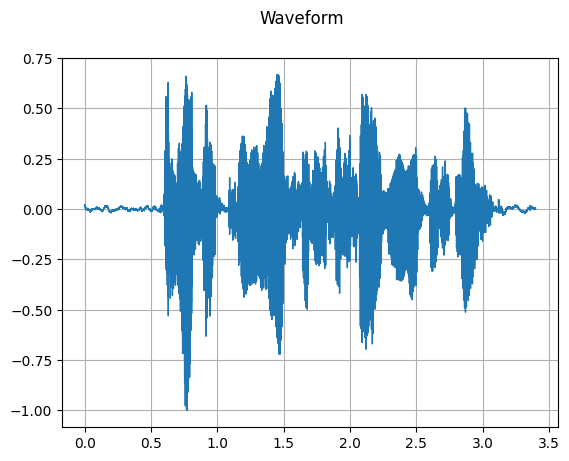

In [ ]:
plot_waveform(waveform, sample_rate)

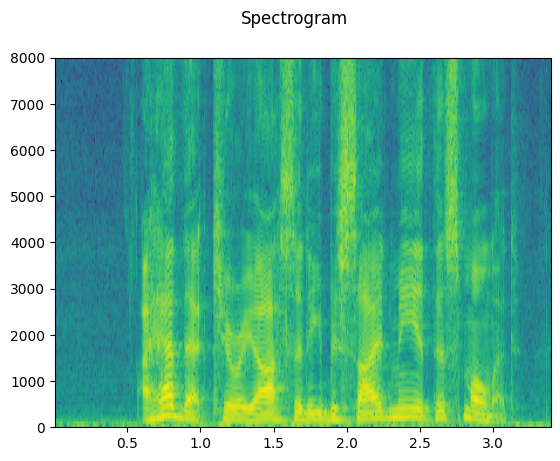

In [ ]:
plot_specgram(waveform, sample_rate)

In [ ]:
# Save audio
path = f"{_SAMPLE_DIR}/save_example_default.wav"
torchaudio.save(path, waveform, sample_rate, encoding="PCM_S", bits_per_sample=16, format="wav")

In [ ]:
# Load again
metadata = torchaudio.info(path)
print(metadata)
waveform, sample_rate = torchaudio.load(path)
play_audio(waveform, sample_rate)

AudioMetaData(sample_rate=16000, num_frames=54400, num_channels=1, bits_per_sample=16, encoding=PCM_S)


In [ ]:
# RESAMPLING
# Resample an audio waveform from one frequency to another
import torchaudio.transforms as T
import torchaudio.functional as F

waveform, sample_rate = torchaudio.load(SAMPLE_WAV_PATH)

resample_rate = 32000

resampler = T.Resample(sample_rate, resample_rate, dtype=waveform.dtype)
resampled_waveform1 = resampler(waveform)

resampled_waveform2 = F.resample(waveform, sample_rate, resample_rate)

play_audio(waveform, sample_rate)
play_audio(resampled_waveform1, resample_rate)
play_audio(resampled_waveform2, resample_rate)

# parameter
# Lowpass filter width
# Larger lowpass_filter_width -> sharper, more precise filter, but more computationally expensive.
resampled_waveform = F.resample(waveform, sample_rate, resample_rate, lowpass_filter_width=12)

# Rolloff
# Lower rolloff reduces the amount of aliasing, but it will also reduce some of the higher frequencies.
resampled_waveform = F.resample(waveform, sample_rate, resample_rate, rolloff=0.80)

# Window function
# default = Hann window filter
resampled_waveform = F.resample(waveform, sample_rate, resample_rate, resampling_method="sinc_interpolation")
resampled_waveform = F.resample(waveform, sample_rate, resample_rate, resampling_method="kaiser_window")

/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:1371: UserWarning: "sinc_interpolation" resampling method name is being deprecated and replaced by "sinc_interp_hann" in the next release. The default behavior remains unchanged.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:1371: UserWarning: "kaiser_window" resampling method name is being deprecated and replaced by "sinc_interp_kaiser" in the next release. The default behavior remains unchanged.
  warnings.warn(
